# Predicting the Sale Price of Houses in Ames

# 1. Problem Statement 

We are employees of a real estate agency in Ames, Iowa who have been tasked with doing market research for the company to find out the features of a house that are the strongest predictors of the sale price of the house and the magnitude to which these features affect the sale price of the house. 

The problem covers both prediction and inference - a) derive sale price **predictions** and b) **infer** the strongest features that affect sale price.

This information can help our company’s agents determine a fair price range for each house and identify the strongest features of each house they sell in order to maximize selling price for our customers. 

### Business context

Without time/resources/expertise to understand everything about a house, the buyer is unable to ascertain his own valuation perfectly.

Because a buyer’s resources are limited, our agents assist the price discovery process such that the buyer is able to arrive at a satisfactory valuation. 

If we are able to highlight features that increase the perceived value and “downplay” features that decrease perceived value - then the price discovered by the buyer will be higher than if he had total information about the house (which is impossible in reality).

This means that we are able to extract additional value from the buyer by tilting the price discovery process in our favor. 

# 2. Imports

In [1]:
import numpy as np
import pandas as pd

# relating to modelling and model evaluation
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, HuberRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold

# pipeline transformers
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# for pipeline construction
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# exporting outputs
import os


# 3. Importing Datasets

A function is defined to import the csv, perform some light formatting on column names, and to set the correct index. Additionally, exception handling is used to handle the test dataset, which is provided without the response variable. The predictions on the test dataset will be verified through a Kaggle submission. 

In [2]:
def df_import_format(path_):
    df = pd.read_csv(path_)
    df.columns = df.columns.str.strip().str.lower().str.replace(' ','_').str.replace('/','_')
    df = df.set_index('id', drop=True, verify_integrity=True)
    try:
        y = df['saleprice']
        X = df.drop(columns='saleprice')
    # to catch the case where there is no saleprice column in the test set
    except:
        X = df
        y = None
    return (X, y)

In [3]:
# returns X and y dataframes for train and test split later
df_train_X, df_train_y = df_import_format('datasets/train.csv')

# For kaggle submissions - expectedly, df_test_y is empty (None type)
df_test_X, df_test_y = df_import_format('datasets/test.csv')

# 3. EDA Part 1 and Data Cleaning

The EDA strategy for this dataset is to sift through each feature to understand its distribution and missing values, while consulting the [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) for context. 

Each feature is sorted into lists which will facilitate separate pipeline treatments and streamline the code for readability:
- categorical nominal
- categorical original
- numeric continuous
- numeric discrete 
- datetime
- features to be dropped

### 3.1 Grouping features by type

Given the manageable number of features, each feature is individually screened and sorted into lists. _pandas.DataFrame.select_dtypes_ is not used because it does not distinguish categorical ordinal and nominal. Numeric continuous and numeric discrete features are also indiscernible. 

In [39]:
response = ['saleprice']

dropped_features = ['pid']

cat_nominal = ['ms_subclass', 'ms_zoning', 'street', 'alley', 'land_contour', 'lot_config',
               'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style',
               'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
               'foundation', 'heating', 'central_air', 'garage_type', 'paved_drive',
               'misc_feature', 'sale_type']

cat_ordinal = ['lot_shape', 'utilities', 'land_slope', 'overall_qual', 'overall_cond', 'exter_qual',
               'exter_cond', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1',
               'bsmtfin_type_2', 'heating_qc', 'electrical', 'kitchen_qual', 'functional',
               'fireplace_qu', 'garage_finish', 'garage_qual', 'garage_cond', 'pool_qc',
               'fence']

numeric_cont = ['lot_frontage', 'lot_area', 'mas_vnr_area', 'bsmtfin_sf_1', 'bsmtfin_sf_2',
                'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
                'gr_liv_area', 'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch',
                '3ssn_porch', 'screen_porch', 'pool_area', 'misc_val']

numeric_discrete = ['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
                    'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 'garage_cars']

datetime_features = ['year_built', 'year_remod_add',
                     'garage_yr_blt', 'mo_sold', 'yr_sold']

# verification that we have sorted everything
print(f'Total number of features sorted: {len(dropped_features + cat_nominal + cat_ordinal + numeric_cont + numeric_discrete + datetime_features)}')
print(f'Total columns in the dataframe {len(df_train_X.columns)}')


Total number of features sorted: 79
Total columns in the dataframe 75


### 3.2 Scanning through all features

Two functions are defined to provide top-level information on the distribution of each feature. For the sake of brevity, the lengthy outputs for all features have been excluded from this code notebook. 

Instead, the functions are provided below, along with three examples of how they were called for each feature. Any notable features found via this screening approach are discussed in this section after the examples.

In [5]:
def info_categorical_feature(feature, df=df_train_X):
    print(df[feature].value_counts(dropna=False))


def info_numeric_feature(feature, df=df_train_X):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.boxplot(data=df, x=feature, ax=axes[0])
    sns.histplot(data=df, x=feature, ax=axes[1])


In [6]:
# an example of usage on a categorical feature
info_categorical_feature('bsmt_cond')


TA     1834
Gd       89
Fa       65
NaN      55
Po        5
Ex        3
Name: bsmt_cond, dtype: int64


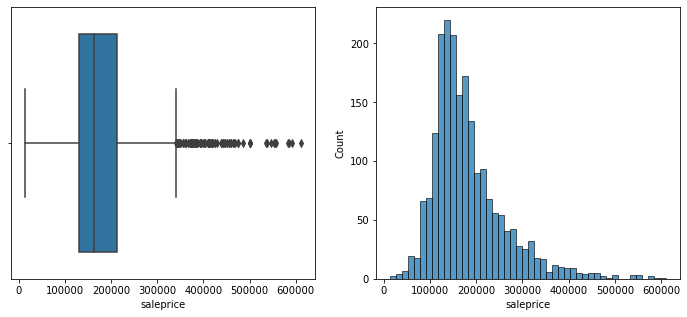

In [7]:
# an example of usage on the response variable
info_numeric_feature('saleprice', df=pd.DataFrame(df_train_y))


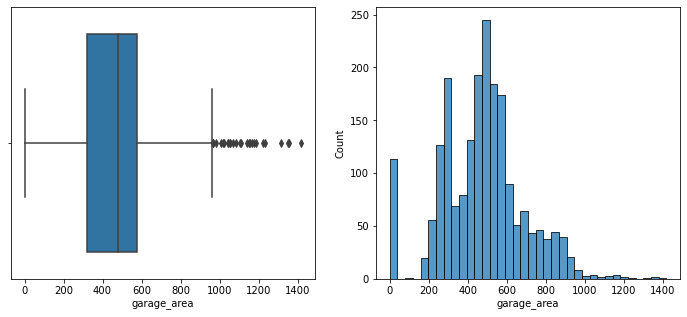

In [8]:
# an example of usage
info_numeric_feature('garage_area')


### 3.3 Notable points from scanning through all features

- The response variable 'saleprice' is continuous and appears to have a gaussian distribution with a positive skew. A log transform of the response can be considered if the initial model does not fit well.

- Missing values are present in a number of features.

- Some numeric features appear to have a gaussian distribution but with a positive skew (like the plot above). Read alongside the box plots, this suggests that there are outliers in the data. A robust model (not unduly affected by outliers) should be used for this dataset. Alternatively, the outliers can be removed if this helps model training. 

- Some categorical features have scarce categories. For example 'utilities' has a majority group of 2049 out of a total of 2051 rows. 'pool_qc' is also another example of a highly unbalanced categorical feature. If One Hot Encoding (OHE) is applied to the categorical features, the resulting matrix might be sparse. 

- Datetime features are also present, these features will need to be engineered into a more useful feature like 'age at sale'.

### 3.4 Handling missing values

For each feature, the count of missing values are tabulated and sorted.

In [9]:
nan_percent = df_train_X.isna().mean()*100
nan_count = df_train_X.isna().sum()

# using concat to stitch the two dataframes together - then chaining sort and head methods
(pd.concat([nan_count.rename('missing_count'), nan_percent.round().rename('missing_percent')], axis=1)
 .sort_values(by='missing_count', ascending=False)).head(25)


,missing_count,missing_percent
pool_qc,2042,100.0
misc_feature,1986,97.0
alley,1911,93.0
fence,1651,80.0
fireplace_qu,1000,49.0
lot_frontage,330,16.0
garage_finish,114,6.0
garage_cond,114,6.0
garage_yr_blt,114,6.0
garage_qual,114,6.0


With the [data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt), it is clear that not all NaN values are truly missing. For some features, NaN has been chosen to denote the *lack of a feature* instead. These NaNs should be replaced with something to denote *'no feature'* instead. A loop is used to replace the NaNs for such cases.

In [10]:
has_missing_values = {'pool_qc': 'no_pool',
                      'misc_feature': 'no_misc_feature',
                      'alley': 'no_access',
                      'fence': 'no_fence',
                      'fireplace_qu': 'no_fireplace',
                      'lot_frontage': 0,
                      'mas_vnr_type': 'no_vnr',
                      'mas_vnr_area': 0,
                      'bsmtfin_type_1': 'no_basement',
                      'bsmt_exposure': 'no_basement',
                      'bsmt_qual': 'no_basement',
                      'bsmt_cond': 'no_basement',
                      'bsmtfin_type_2': 'no_basement',
                      'garage_type': 'no_garage',
                      'garage_yr_blt': 'no_garage',
                      'garage_finish': 'no_garage',
                      'garage_qual': 'no_garage',
                      'garage_cond': 'no_garage'}

# lot_frontage - Looking at the distribution, the min value is 21.
# For this feature, it is likely that NaN means no lot frontage, NaN replaced with 0

# the test set can also be imputed in this way, without any data leakage
for key, value in has_missing_values.items():
    df_train_X.loc[df_train_X[key].isna(), key] = value
    df_test_X.loc[df_test_X[key].isna(), key] = value


In [11]:
# remaining missing values
df_train_X.isna().sum().sort_values(ascending=False).head(10)


bsmt_half_bath    2
bsmt_full_bath    2
total_bsmt_sf     1
bsmt_unf_sf       1
bsmtfin_sf_2      1
garage_cars       1
bsmtfin_sf_1      1
garage_area       1
bedroom_abvgr     0
functional        0
dtype: int64

The remaining missing values are really missing data. These will need to be imputed in the model pipeline.

# 4. Feature Engineering

A total of 5 datetime features are present in the dataset. Two new features are engineered from these datetime features.

- 'year_built' - An 'age_at_sale' feature can be engineered by taking the difference between 'year_built' and 'yr_sold'

- 'year_remod/add' - A 'years_since_remodel' feature can be engineered by taking the difference between 'year_remod_add' and 'yr_sold'

Two new functions are defined to create these features in both the test and train sets.

In [12]:
def create_age_at_sale(df):

    original_num_rows = len(df)
    df.loc[:, 'age_at_sale'] = df['yr_sold'] - df['year_built']

    # we have one negative age at ID 2181, clearly a mistake in the data so choose to drop
    df = df.loc[df['age_at_sale'] >= 0, :]

    print(
        f'creating "age_at_sale" {original_num_rows - len(df)} rows removed from dataframe')

    return df


In [13]:
def create_years_since_remodel(df):

    original_num_rows = len(df)
    df.loc[:, 'yrs_since_remod'] = df['yr_sold'] - df['year_remod_add']

    # we have one negative yrs_since_remod at ID 1703, clearly a mistake in the data
    df.loc[df['yrs_since_remod'].isna(), 'yrs_since_remod'] = df['age_at_sale']

    # impute with age at sale - if the house was never remodeled
    df.loc[df['yrs_since_remod'] < 0, 'yrs_since_remod'] = df['age_at_sale']

    print(
        f'creating "yrs_since_remod" {original_num_rows - len(df)} rows removed from dataframe')

    return df


In [14]:
# calling functions to engineer new features on both test and train frames

# the function calls may throw a false positive warning - this suppresses the warning
pd.options.mode.chained_assignment = None  # default='warn'

print('Train set - creating new features')
df_train_X = create_age_at_sale(df_train_X)
df_train_X = create_years_since_remodel(df_train_X)

print('\nTest set - creating new features')
df_test_X = create_age_at_sale(df_test_X)
df_test_X = create_years_since_remodel(df_test_X)

Train set - creating new features
creating "age_at_sale" 1 rows removed from dataframe
creating "yrs_since_remod" 0 rows removed from dataframe

Test set - creating new features
creating "age_at_sale" 0 rows removed from dataframe
creating "yrs_since_remod" 0 rows removed from dataframe


### 4.1 Analyzing the new features - Age at Sale / Yrs Since Remodelling

- Age at sale appears to be exponentially distributed with some outliers, which are houses that are more than 120 years old at the point of sale.

- Years since remodelling has a bimodal distribution. The feature was engineered this way; houses which were never remodelled have this value imputed with its age at sale instead. Essentially, this feature is attempting to capture the *effective age* of a house, since very old houses can be remodelled and have a younger perceived age.

- Together, these two features attempt to capture the age of the house.

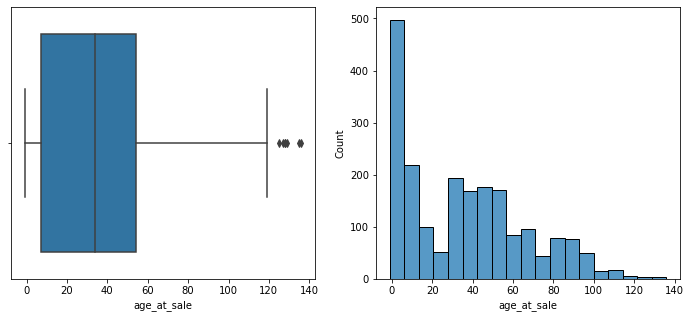

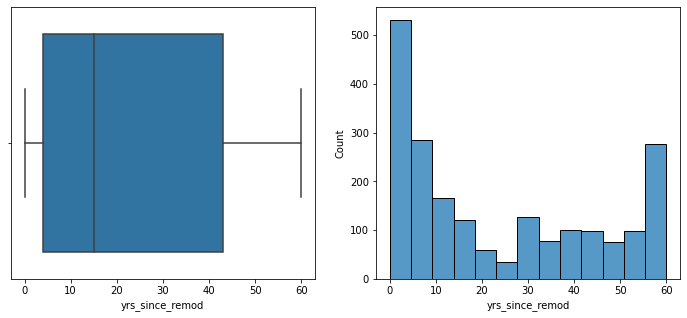

In [15]:
# visualise these two new features
info_numeric_feature('age_at_sale')
info_numeric_feature('yrs_since_remod', df=df_train_X)


### 4.2 Tracking newly-engineered features in both test and train sets

- Lastly, the functions that created these features remove rows where the age is negative, which is a likely error in the original data. The dropped rows will also need to be removed from the y dataframe so both dataframes are the same length. 

- Additionally, the newly engineered features will need to be tracked and the unused datetime features should be dropped.

In [16]:
# finding missing indices that were dropped in X, making sure that y is the same length
dropped_indices = list(set(df_train_y.index).difference(set(df_train_X.index)))
df_train_y = df_train_y.drop(index=dropped_indices)
print(f'Index {dropped_indices} dropped from the train_y dataframe')

# this doesn't need to be done for the test set as there is no y dataframe for the test


Index [2181] dropped from the train_y dataframe


In [17]:
# track newly created features in the list of numeric columns
numeric_cont.extend(['age_at_sale', 'yrs_since_remod'])

# updating the 'drop list' with the other datetime features which are no longer required
dropped_features.extend(datetime_features)


# 5. EDA Part 2 - Correlation plot

Once new features have been created, a final EDA is undertaken with all the features present.

A Pearson's correlation plot is used to provide a high-level scan of potential relationships between numeric variables. Note that this does not show any information on categorical features.

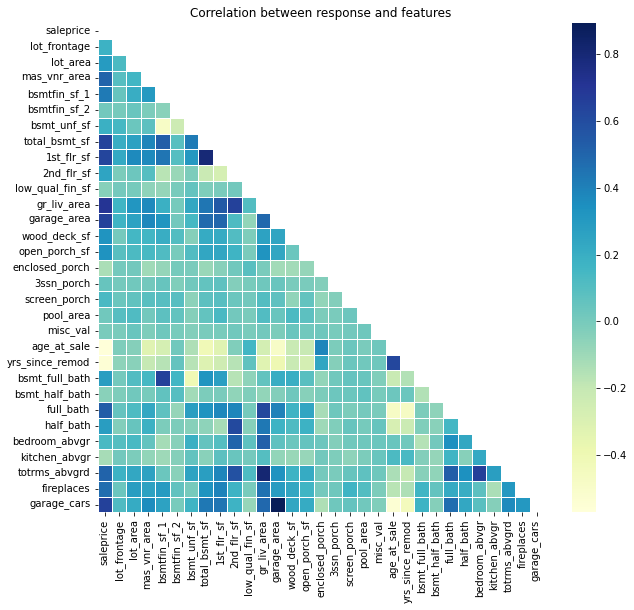

In [18]:
corr_df = df_train_y.to_frame().merge(
    df_train_X, left_index=True, right_index=True)

# limiting the data frame to only the numeric columns - then chaining the corr method
corr_df = corr_df[response + numeric_cont + numeric_discrete].corr()

# creating a white mask for the top triangle of the correlation matrix to improve readability
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(figsize=(10, 9))
sns.heatmap(corr_df, linewidths=.5, cmap='YlGnBu', mask=mask).set(
    title='Correlation between response and features')


Features correlated with the response: (+ or -) denotes positive or negative correlation respectively:

- (+) 'mas_vnr_area' - Masonry veneer area
- (+) 'total_bsmt_sf' - Total basement area
- (+) '1st_flr_sf' - First Floor area
- (+) 'gr_liv_area' - Above ground living area
- (+) 'garage_area' - Size of garage
- (+) 'full_bath' - Full bathrooms above ground
- (+) 'totrms_abvgrd' - Total rooms above ground 
- (+) 'garage_cars' - Size of garage in car capacity

- (-) 'age_at_sale' - Age of the house at the point of sale
- (-) 'yrs_since_remod' - Years since remodeling or additions at the point of sale

The correlation plot also suggests [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity), which is high correlation between the features. Potentially, a regression model may have a high chance of overfitting (high noise).

# 6. Model Feasibility

### 6.1 Appropriateness of regression models

- The response variable 'saleprice' is a numeric continuous variable. A regression approach is proposed to model the data and make sale price predictions.

- Regression is ideal for this business context because ease of interpretation is important to stakeholders. Additionally, individual feature effects can also be inferred from regression models by looking at the feature coefficients. 

- Features are a mix of numerical and categorical variables, regression models can handle this well if numeric features are scaled (for regularized regressions) and categorical variables are encoded.

- There are technical assumptions for regressions which will be tested after model development.

### 6.2 Overcoming potential challenges in the data

1. Outlier data points are present in this dataset and can often make regression lines less accurate.

2. Multicollinearity. Potentially, a regression model may have a high chance of overfitting (high noise).

Theses challenges can each be addressed through the use of regularized regressions (Lasso and Ridge) and their hybrids (Elastic net and the Huber Regressor).

Outliers in the data may require a robust model and the [Huber Regressor](https://artowen.su.domains/reports/hhu.pdf) comes to mind. The multicollinearity problem also necessitates regularization and models like the Elastic Net has been shown to be [robust to extreme correlations among predictors](https://pubmed.ncbi.nlm.nih.gov/20808728/).

The chosen strategy is to first evaluate if regularized models can effectively deal with the challenges in this dataset before more extreme methods like dropping outliers and collinear features are considered. 

### 6.3 Feature selection for regression

Given the large number of features, a possible approach might be to consider feature selection, either manually prior to modelling or as part of the sklearn pipeline. 

However, first consider  that the data is far from being considered high-dimensional, which is when the number of features rivals or even exceeds the number of observations [(source)](https://www.stat.cmu.edu/~ryantibs/advmethods/notes/highdim.pdf). Even if this is the case, regularization methods like Ridge have empirical success in high dimensional datasets and when features are highly correlated [(source)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.87.8588&rep=rep1&type=pdf). 

Therefore, feature selection/dimensionality reduction is not theoretically required. Still there are practical benefits from feature selection/dimensionality reduction prior to regression:

1. Reduced resource consumption in training
2. Controlling for overfitting
3. Ease of interpretation by stakeholders
4. Ease of making future predictions in a production model

In this case, the reduction in resources required is negligible. Given the size of this dataset and well-implemented regularization paths in sklearn, training these regression models should only take a few minutes on a modern computer. Overfitting is also controlled by the presence of regularization, which can be tuned via their respective hyperparameters.

As for interpretation by stakeholders, the regression model is an easily understood parametric model. Regardless of the number of variables, the coefficients for each feature can be individually explained. 

However, parsimony may still be desirable in the final production model. The more complex the model, the more data will be required to make future predictions outside of the test set. This is a matter that should be discussed with stakeholders if a production model is required.

### 6.4 Summary of Model Feasibility

- Regression models are appropriate for this problem.

- Potential challenges can be mitigated with various regularized models. Each model will need to be tested for performance as different regularization approaches have their own strengths.

- Feature selection is not theoretically necessary for this problem but can be considered on practical grounds. No feature selection is implemented for now.

# 7. Regression Modeling

The dataframes are finalized, with unusable features (id tags and untransformed datetime features) removed. The training set is split via a random train test split. Note that the data leakage has been controlled up to this point because no column-wise feature scaling has been executed.

In [19]:
# finalizing dataframes - dropping unwanted features highlighted in EDA and feature engineering
df_train_X = df_train_X.drop(columns=dropped_features)
df_test_X = df_test_X.drop(columns=dropped_features)

# train test split - must specify random sta=te for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    df_train_X, df_train_y, test_size=0.2, random_state=42)


Tracking of numeric features is updated, with no distinction between numeric continuous and numeric discrete features.

Tracking of categorical features is also updated with no distinction between ordinal and nominal features. Note that with this approach, the ordinal ranking information is lost for these features and the model effectively treats these ordinal categories as categorical nominal features. 

Using the information encoded in ordinality is a difficult problem, the _"values exists on an arbitrary scale where only the relative ordering between different values is significant"_ and more advanced methods [(source)](https://en.wikipedia.org/wiki/Ordinal_regression#:~:text=In%20statistics%2C%20ordinal%20regression%2C%20also,between%20different%20values%20is%20significant) can be considered in a future execution. 

In [20]:
# bundling numeric and categorical features for the column transformer
numeric_features = numeric_cont + numeric_discrete
cat_features = cat_nominal + cat_ordinal 

5 regression models are tested:

- Multiple linear regression (aka sklearn's Linear Regression)

- Lasso Regression (trained with l1 regularization term)

- Ridge Regression (trained with l2 regularization term)

- Elastic Net Regression (trained with both l1 and l2 regularization terms, the convex combination is controlled with a l1_ratio parameter)

- Huber Regression*

*The Huber Regression is a robust penalized (regularized) regression [(source)](https://artowen.su.domains/reports/hhu.pdf). It is different from Ridge because it applies a l1 linear loss to samples that are classified as outliers, while inliers are subject to a less aggressive l2 loss. An example of how Huber Regression is robust to outliers can be found in [sklearn's documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_huber_vs_ridge.html#sphx-glr-auto-examples-linear-model-plot-huber-vs-ridge-py).

While not as common as the Elastic Net, the Huber Regressor was selected because outliers are present in this dataset. Additionally, the Huber is capable of yielding sparse regression coefficients, similar to it's Lasso counterpart.

In [21]:
# some models have random states, which need to be specified for reproducibility
# lasso, Ridge, E-Net are called in their CV versions with innate hyperparameter tuning

test_models = {
    'LinearRegression': LinearRegression(),
    'Lasso': LassoCV(random_state=42, n_jobs=-1),
    'Ridge': RidgeCV(),
    'ElasticNet': ElasticNetCV(l1_ratio=[.1, .5, .9, .95, .99, 1], random_state=42, n_jobs=-1),
    'Huber': HuberRegressor(epsilon=1.35, alpha=0.0001, max_iter=10000),
}


The following code blocks create individual model pipelines for each of the 5 models and stores them in a dictionary. 

A sklearn [column transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) is used in the pipeline so numeric features can be processed differently from categorical ones.

After separate preprocessing, all features are fed into the estimator, which is one of the five regression models. 

In [22]:
# instantiate a dictionary to store all constructed model pipelines
model_pipes = {}

for model_name, model in test_models.items():

    numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy='median')),
                                          ('scaler', MinMaxScaler())
                                          ])

    categorical_transformer = Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='most_frequent')),
                                              ('onehot', OneHotEncoder(
                                                  handle_unknown='ignore'))
                                              ])

    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, cat_features)
                      ])

    model_pipes[model_name] = Pipeline(steps=[('preprocessor', preprocessor),
                                              ('estimator', model)
                                              ])


In [23]:
# display a diagram of the pipeline as an example
set_config(display='diagram')
model_pipes['Lasso']


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['lot_frontage', 'lot_area',
                                                   'mas_vnr_area',
                                                   'bsmtfin_sf_1',
                                                   'bsmtfin_sf_2',
                                                   'bsmt_unf_sf',
                                                   'total_bsmt_sf',
                                                   '1st_flr_sf', '2nd_flr_sf',
                                                   'low_qual_fin_sf',
                                                   'gr_liv_area', 'garage_area',
                                                   'wood_deck_s...
                                                   'condition_1', 'condition_2',
                                                   'bldg_type', 'house_style',
                                                   'roof_style', 'roof_matl',
                                                   'exterior_1st',
                                                   'exterior_2nd',
                                                   'mas_vnr_type', 'foundation',
                                                   'heating', 'central_air',
                                                   'garage_type', 'paved_drive',
                                                   'misc_feature', 'sale_type',
                                                   'lot_shape', 'utilities',
                                                   'land_slope', 'overall_qual',
                                                   'overall_cond', 'exter_qual',
                                                   'exter_cond', ...])])),
                ('estimator', LassoCV(n_jobs=-1, random_state=42))])

The above html diagram is a graphical representation of the pipeline, with separate sub-pipelines for numeric (num) and categorical (cat) features.

**Numeric feature sub-pipeline**

- Simple imputer is used to fill any missing values with the median value of that feature. A 'mean' strategy may not be so effective because some features have heavily skewed distributions.

- MinMaxScaler will scale numeric features to a 0 to 1 range. This scale matches up with the scale of the categoric features, which will be encoded into 0 and 1s. Consistent scaling between features, even of different type, is essential for most regularized regressions.

**Categorical feature sub-pipeline**

- Simple imputer fills any missing values with the 'most_frequent' category within that feature.

- OneHotEncoder then encodes the categorical features as a one-hot numeric array. Note that because the data is later fed into a regularized linear regression model, the drop ‘first’ argument is not set. These are two convincing discussions which support this decision to keep all categories when regularisation is employed. [(source 1)](https://stats.stackexchange.com/questions/511112/should-one-hot-encoding-or-dummy-variables-be-used-with-ridge-regression) [(source 2)](https://stats.stackexchange.com/questions/231285/dropping-one-of-the-columns-when-using-one-hot-encoding)

# 8. Evaluating Models

### 8.1 Cross Validated Scoring

For each model, r2 scores are evaluated by cross-validation (10-fold).

In [24]:
# cross validation scores for each model
for model_name, model_pipe in model_pipes.items():

    # using shuffle split to shuffle the data for cross val score - must specify random state for reproducibility
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    cvs = cross_val_score(model_pipe, X_train, y_train,
                          cv=kf, scoring='r2', n_jobs=-1)

    print(f'{model_name} cross validation scores (measured in r2)')
    print(f'Score for each fold: {cvs.round(3)}')
    print(f'Mean cross validated score: {np.mean(cvs):.3f}\n')


LinearRegression cross validation scores (measured in r2)
Score for each fold: [0.911 0.888 0.929 0.917 0.853 0.933 0.871 0.11  0.898 0.925]
Mean cross validated score: 0.823

Lasso cross validation scores (measured in r2)
Score for each fold: [0.923 0.91  0.92  0.93  0.921 0.931 0.879 0.293 0.9   0.937]
Mean cross validated score: 0.854

Ridge cross validation scores (measured in r2)
Score for each fold: [0.902 0.886 0.88  0.915 0.905 0.916 0.855 0.276 0.897 0.912]
Mean cross validated score: 0.835

ElasticNet cross validation scores (measured in r2)
Score for each fold: [0.923 0.91  0.92  0.93  0.921 0.931 0.879 0.293 0.9   0.937]
Mean cross validated score: 0.854

Huber cross validation scores (measured in r2)
Score for each fold: [0.917 0.912 0.921 0.932 0.915 0.934 0.876 0.446 0.901 0.931]
Mean cross validated score: 0.869



Based on the cross-validated r2 scores, which measures the variation in the response that can be explained by the model, all models perform well as all r2 scores exceed 0.8. 

|Model|Mean cross validated score|
| --- | --- |
|Huber|0.869|
|ElasticNet|0.854|
|Lasso|0.854|
|Ridge|0.835|
|Linear Regression*|0.823|

As expected, the unregularized linear regression fares the worst. The Huber Regressor performs the best, presumably due to the Huber being better at handling outliers in the dataset, while still preventing overfitting. 

**A technical aside on sklearn's output for the OLS linear regression*:

Linear regression is still able to return a solution, despite one hot encoding creating a dummy variable trap (perfect multicollinearity) since drop='first' was not specified. How then is sklearn's linear regression still able to solve the OLS optimization problem?

The intuition is that the now undetermined system has many solutions and sklearn's [linalg.lstsq](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html) solver is returning just one of the solutions for the linear regression. The solver is probably using gradient descent and is unable to know that it is solving for a multitude of solutions.

Naturally, this particular linear regression model will not be considered for production.

### 8.2 Test for overfitting with unseen data

In [25]:
# training the models
for model_name, model_pipe in model_pipes.items():
    # fitting each model to the training data
    model_pipe.fit(X_train, y_train)

    print(f'{model_name} trained')
    print(
        f'train r2={model_pipe.score(X_train, y_train):.5f}, test r2={model_pipe.score(X_test, y_test):.5f}')


LinearRegression trained
train r2=0.94744, test r2=0.93164
Lasso trained
train r2=0.93794, test r2=0.93218
Ridge trained
train r2=0.91585, test r2=0.90709
ElasticNet trained
train r2=0.93794, test r2=0.93218
Huber trained
train r2=0.91058, test r2=0.92995


The models are then tested against the holdout test data to check for overfitting. The small gap between train and test r2 scores suggests that there is minimal overfitting for all models. 

For the regularized models, this result is expected. However, the linear regression result is surprising since it suggests that minimal overfitting is occurring even without regularization. 

### 8.3 Evaluating Model Interpretability

Plotting the features with the strongest effect on the sale price for each model.

Only the top 5 and bottom 5 features are shown.

In [26]:
def model_feature_plot(model_name, model_pipe, top=10, bottom=10):

    # feature coefficients at the estimator step of  the pipeline
    model_coef = model_pipe['estimator'].coef_

    # feture names will be the numeric feature names + the OHE categorical feature names
    feature_names = numeric_features + list(model_pipe['preprocessor'].transformers_[1][1][1]
                                            .get_feature_names_out(cat_features))

    # creating a dataframe with the feature coefficients and feature names
    model_coef_df = pd.DataFrame(
        model_coef, index=feature_names, columns=['coef'])

    # top 10 and bottom 10 features which have the most impact on the target
    sorted_coef_df = model_coef_df.sort_values(by='coef', ascending=False)

    # slicing the best and worst 10 features, and then labelling them
    impt_features = pd.concat(
        [sorted_coef_df.head(top), sorted_coef_df.tail(bottom)])
    impt_features['strength'] = impt_features['coef'].apply(
        lambda x: 'Bottom' if x < 0 else 'Top')

    # plotting
    (sns.barplot(data=impt_features, x='coef', y=impt_features.index, orient='h', hue='strength').
     set(title=f'{model_name}'))


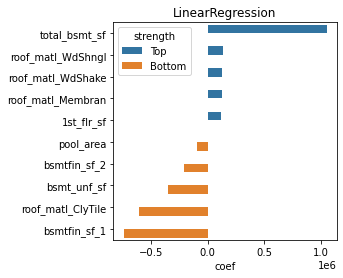

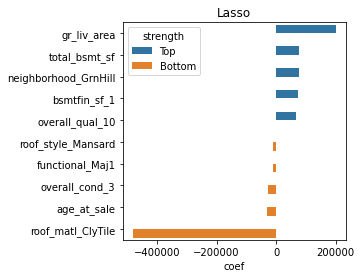

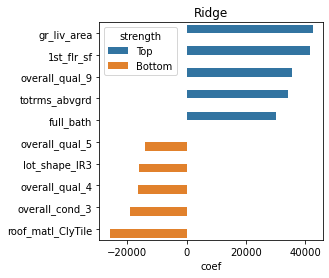

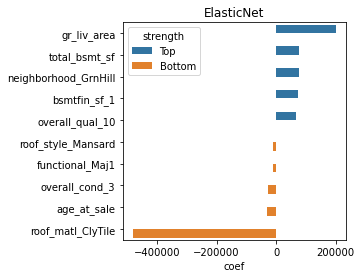

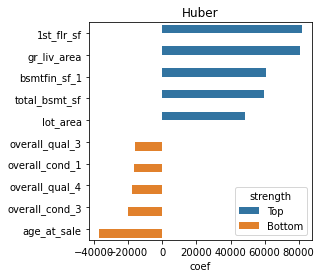

In [27]:
# plotting strongest features for each model - to get a handle on interpretability
for model_name, model_pipe in model_pipes.items():
    fig, axes = plt.subplots(figsize=(4, 4))
    model_feature_plot(model_name, model_pipe, top=5, bottom=5)


The larger the coefficient, the more it affects the final sale price, ceteris paribus. Features with positive coefficients increase the sale price, while features with negative coefficients are detrimental.

- Across models, some key features float to the very top: total_bsmt_sf, gr_liv_area, 1st_flr_sf, neighborhood_GrnHill, high overall_qual

- Likewise, across the models some features also sink to the bottom of the list: poor overall condition or quality, and age_at_sale

- Some coefficients are highly positive or negative in some models. The hypothesis is that this is due to outliers in data. The Linear Regression, Lasso, and Elastic Net seem to have trouble coping with outliers based on these plots. It also turns out that there is only one observation where the roof material (roof_matl) is clay tile (ClyTile), which is likely to have caused the extreme negative coefficient in the Lasso and Elastic Net models.

- Huber and Ridge models have more 'balanced 'coefficients

# 9. Model Selection 

The five models are evaluated across three criteria selected for this business problem:

1. Accuracy - This is measured by cross-validated r2 score and the model's ability to prevent overfitting. Based on earlier results, overfitting doesn't seem to be an issue for all models. In terms of accuracy via cross-validated r2 scores, the Huber model is ahead.

2. Interpretability - A subjective measure of usefulness in solving the business problem. As a recap, the objective is to discover features that increase the perceived value of a house and downplay features that decrease perceived value. The plots of the strongest features (top 5 and bottom 5) answers this. While all models are able to deliver on this point, the Linear Regression, Lasso, and Elastic Net produce a few "extreme" coefficients which are questionable. Huber and Ridge models have more 'balanced 'coefficients and are thus more interpretable and useful to stakeholders.

3. Parsimony - This is a measure of the model's simplicity. Across the board, these linear models are whitebox models and are simple to explain. What differs is the features required by the model to make new predictions. All the models, except Lasso and Elastic Net, require almost all the features provided in the dataset. Only Lasso and Elastic Net have "zeroed" out features by assigning zero coefficients to the "weaker" features.

**Summary of the model selection criteria (measures are relative to other models)**

|Model|Accuracy|Interpretability|Parsimony|
| --- | --- | --- |--- |
|Huber|**Good**|**Good**|Poor|
|ElasticNet|Average|Poor|**Good**|
|Lasso|Average|Poor|**Good**|
|Ridge|Average|**Good**|Poor|
|Linear Regression|Poor|Poor|Poor|

Based on all three dimensions, the Huber Regressor offers the best tradeoff in offering high accuracy and interpretability but at the cost of using all the features in the model.

In [28]:
# demonstration of features zeroed out by the various models
total_features = len(model_pipes['LinearRegression']['estimator'].coef_)

for key in model_pipes.keys():
    zeroed = (model_pipes[key]['estimator'].coef_ == 0).sum()
    print(f'{key} has {total_features - zeroed} columns')


LinearRegression has 329 columns
Lasso has 154 columns
Ridge has 329 columns
ElasticNet has 154 columns
Huber has 329 columns


### 9.1 Tuning the Huber Regressor

The Huber Regressor has two hyper parameters within [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html):

- Epsilon controls the number of samples that should be classified as outliers. The smaller the epsilon, the more robust it is to outliers.

- Alpha is the regularization parameter.

A grid search over the Huber pipeline will be used to tune the hyperparameters.

In [29]:
# finalizing the final model pipeline for the HuberRegressor

numeric_transformer = Pipeline(steps=[('num_imputer', SimpleImputer(strategy='median')),
                                      ('scaler', MinMaxScaler())
                                      ])

categorical_transformer = Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(
                                              handle_unknown='ignore'))
                                          ])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, cat_features)
                  ])

tuned_huber = Pipeline(steps=[('preprocessor', preprocessor),
                              ('estimator', HuberRegressor(
                                  epsilon=1.35, alpha=0.0001, max_iter=10000))
                              ])


In [30]:
# setting up the grid search with huber hyperparameters
param_grid = {'estimator__epsilon': [1.01, 1.05, 1.10, 1.30, 1.35],
              'estimator__alpha': list(np.logspace(-7, -3, num=5))}

# instantiating the GridSearchCV object
kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(tuned_huber, param_grid,
                           cv=kf, scoring='r2', n_jobs=-1)

# cross-validated search for the best hyper-parameters combination
grid_search.fit(X_train, y_train)

# gridsearch results are stored in a dataframe if required
cv_results = pd.DataFrame(grid_search.cv_results_)

print("Best params:")
print(grid_search.best_params_)
print(f"Internal CV score: {grid_search.best_score_:.3f}")


Best params:
{'estimator__alpha': 0.0001, 'estimator__epsilon': 1.1}
Internal CV score: 0.870


In [32]:
tuned_huber = grid_search.best_estimator_

In [31]:
tuned_huber.fit(X_train, y_train)
print(f'train r2={tuned_huber.score(X_train, y_train):.5f}, test r2={model_pipe.score(X_test, y_test):.5f}')

train r2=0.91058, test r2=0.92995


The hyperparameter tuning has increased the cross-validated r2 score from 0.869 to 0.870. There is still no sign of overfitting and the model is performing well against unseen data. The final tuned model is assigned to `tuned_huber`

### 9.2 Regression assumptions with the finalized model 

Before interpreting and retrieving insights from the finalized model, the technical assumptions for regression are revisited.

- Linearity and Additivity
- Statistical independence of the errors 
- Homoscedasticity
- Normality of the error terms

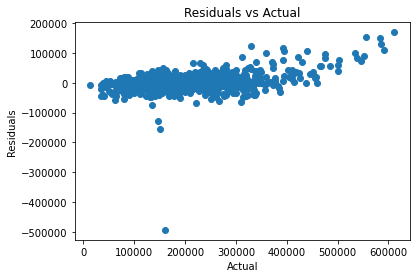

In [33]:
y_pred = tuned_huber.predict(X_train)
residuals = y_train - y_pred
residuals

plt.scatter(y_train, residuals)
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual')


**Plotting residuals against fitted values**

- Shows that outliers are present in the data
- Slight upward curve of the data suggest that the model doesn’t capture some non-linear effects
- No indication of heteroscedasticity as the spread is not funnel-shaped

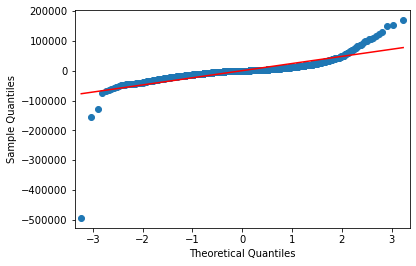

In [34]:
sm.qqplot(residuals, line='s');

**Normal Q-Q Plot**

- Shows that errors are not normally distributed

### 9.3 Violating assumptions: Is the model still valid?

The model does not fulfil the technical assumptions for linear regression. 

Whether the model is valid should instead depend on whether the objective is prediction or inference. It is possible to argue that this business problem requires a little bit of both. The task is to create a regression model to predict the price of a house at sale. In this regard the model achieves the objective; cross-validated scores are good and the model generalizes well to unseen data without overfitting.

On the other hand, the above tests casts doubt about the unbiasedness of the feature coefficients. Inference, in the context of understanding the feature coefficients, is hampered.

However, the real elephant in the room is whether such technical assumptions matter in the context of regularized regression techniques. The strength of such techniques is to "make a biased estimate of regression parameters" as quoted from this [online discussion](https://stats.stackexchange.com/a/183198). The commenter then goes on to make an excellent argument about technical assumptions when regularization is applied:

_The whole point of these methods is to make a biased estimate of regression parameters, and hoping to reduce the expected loss by exploiting the bias-variance trade-off... It is therefore not clear to me how there can be any theoretical optimality statement about β^, and so I am not sure that talking about "assumptions" (presence or absence thereof) of penalized methods such as ridge regression makes sense at all._

As a conclusion to this chapter on model selection - the model is indeed valid in the context of the business task of delivering prediction accuracy. Inference (of the coefficients) is not as statistically rigorous as desired, due to the violated regression assumptions, but that is the tradeoff in delivering a strong predictive model within the constraints.

# 10. Insights from the Final Model

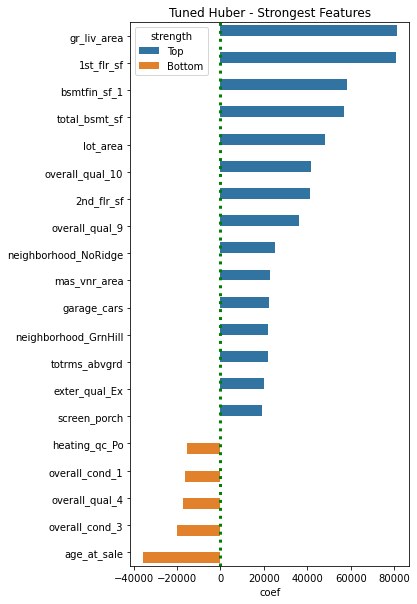

In [35]:
# strongest feature plot from the best model
fig, axes = plt.subplots(figsize=(5, 10))
plt.axvline(x=0, color='g', linestyle=':', linewidth=3)
model_feature_plot('Tuned Huber - Strongest Features',
                   tuned_huber, top=15, bottom=5)


### 10.1 Features that have the most effect on the value of the home

The regression coefficient is a measure of positive or negative correlation between each feature and the response. The larger the magnitude, the stronger this effect is. 

A technical note: By defining the response and features at the start of the project, the causal relationship has already been assumed. In this case, it seems intuitive that the instances of these features (age, condition, etc) should necessarily precede the instance when the sale price is determined. Indeed, the causal relationship between the features and response has some backing because of this.

**Features that add the most value to a home (strongest to weakest):**

- Gr Liv Area: Above grade (ground) living area square feet
- 1st Flr SF: First Floor square feet
- BsmtFin SF 1: Type 1 finished square feet*
- Total Bsmt SF: Total square feet of basement area
- Lot Area: Lot size in square feet
- Overall Qual: Rates the overall material and finish of the house - high ranking of 10 or 9**
- 2nd Flr SF: Second floor square feet
- Neighborhood - Northridge or Green Hills neighborhoods
- Mas Vnr Area: Masonry veneer area in square feet
- Garage Cars: Size of garage in car capacity
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- Exter Qual: Evaluates the quality of the material on the exterior - high rating of Excellent**
- Screen Porch: Screen porch area in square feet

**Features that diminish the value of a home (strongest to weakest):**

- Age at sale 
- Overall Cond: Rates the overall condition of the house - low ranking of 3 and below**
- Overall Qual: Rates the overall material and finish of the house - low ranking of 4 and below**
- HeatingQC: Heating quality and condition - low rating of Poor**

_Fine print - Some features are not perfectly interpretable due to the choice of model_

*BsmtFin SF 1: Type 1 finished square feet needs to be interpreted as an interaction between the rating of basement finished area and the total square feet of this finish. This is not immediately clear from the chart.

**Ordinal features were encoded as categorical nominal so direct interpretation of all the ordinal categories above/below the level depicted is difficult. When a feature like overall_cond_3 shows up on the chart, then the assumption is that overall_cond_2 and overall_cond_1 are obviously "worse" features and should adversely affect sale price even more. This logical leap can only be surmised and is not obvious from the model. 

### 10.2 Business Recommendations

In [36]:
# saving the model coefficients as a csv for stakeholder reference

# feature coefficients at the estimator step of  the pipeline
model_coef = tuned_huber['estimator'].coef_

# feature names will be the numeric feature names + the OHE categorical feature names
feature_names = numeric_features + list(tuned_huber['preprocessor'].transformers_[1][1][1]
                                        .get_feature_names_out(cat_features))

# creating a dataframe with the feature coefficients and feature names
model_coef_df = pd.DataFrame(model_coef, index=feature_names, columns=['coef'])

# write the coefficients dataset to a csv
if not os.path.exists('output'):
    os.makedirs('output')
model_coef_df.to_csv('output/model_coefficients.csv')


- Agents should pay close attention to highlight features that have a strong positive coefficient because these features have a positive impact on sale price. Likewise, features with negative coefficients should be downplayed. Agents may take reference from the chart above or refer to the [`model_coefficients.csv`](output/model_coefficients.csv) for the full list of features and coefficients. 

- If houses are to be refurbished by the Ames agency prior to market listing, overall quality (material and finish) should be prioritized over overall condition of the house. Overall quality has a stronger impact than condition according to the model. 

- When prospecting for houses to sell, agents should focus on neighborhoods like Northridge or Green Hills. These locations have a positive impact on sale price. More expensive sale prices directly contribute to higher commissions. 

- Before engaging a client, agents are advised to predict the sale price with the model. This allows agents to more objectively understand the [zone of possible agreement](https://www.investopedia.com/terms/z/zoneofpossibleagreement.asp) before negotiations with both buyers and sellers.

# 11. Conclusion

The business problem covers both prediction and inference - a) derive sale price **predictions**, and b) **infer** the strongest features that affect sale price.

A regression approach was selected for this business problem. Five different regression models were shortlisted and then evaluated across three criteria specially selected for this business problem: 

1. Predictive accuracy
2. Interpretability of the coefficients
3. Parsimony (number of features required by the model)

Based on all three dimensions, the Huber Regressor offers the best tradeoff in offering high accuracy and interpretability but at the cost of using all the features in the model.

For the first deliverable, the final tuned model achieves respectable predictive accuracy. The cross-validated r2 score is 0.870 and the model performs well against unseen data with no overfitting.

As for the second deliverable, while there are some caveats on the statistical rigor required for inference, the model is still able to generate reasonable feature coefficients for all features. The strongest feature chart and [`model_coefficients.csv`](output/model_coefficients.csv) were created for this purpose.

### 11.1 Future steps

- Further model refinement is possible. Polynomial and interaction features deserve some attention in this dataset. 

- Steps can also be taken to move the model into production. Ideally an app interface can be created for stakeholders so that "predictions on demand" can be retrieved from the model instead of batch-processed. Stakeholders may also wish for business analytics to be displayed via a dashboard. 

- Lastly, the current model does not generalize well to other cities as geographical data like neighborhood categories have significant bearing on predictions as inferred from the model. If equivalent neighborhood data can be obtained for other cities, perhaps this same model (once trained) may have a chance of obtaining accurate predictions for other cities.

### Annex: Submission to kaggle

As part of the submission, the model predictions are submitted to the [DSI-US-11 Regression Challenge](https://www.kaggle.com/c/dsi-us-11-project-2-regression-challenge). 

Private Score - Root Mean Square Error of **19751.85955** (12th place if the competition was still open)

In [37]:
test_predictions = pd.DataFrame(tuned_huber.predict(df_test_X), index= df_test_X.index, columns=['SalePrice'])

# write the predictions dataset to a csv
if not os.path.exists('output'):
    os.makedirs('output')
test_predictions.to_csv('output/test_predictions_huber3.csv')